In [1]:
from importlib import reload
import torch
import torch.nn.functional as F
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score

import data
reload(data)
from data import AmlsimDataset

import modules
reload(modules)
from modules import GCN, GCN_GNNExplainer, GCN_GraphSVX
from modules import GraphSAGE
from torch_geometric.data import DataLoader
import torch.optim as optim
from torch_geometric.utils import to_networkx

import matplotlib.pyplot as plt

%matplotlib inline
import networkx as nx
from torch_geometric.data import Data
import torch_geometric
import numpy as np


In [2]:
# Set device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [3]:
# Load data
traindata = AmlsimDataset(node_file='data/simulation3/swedbank/train/nodes.csv', edge_file='data/simulation3/swedbank/train/edges.csv', node_features=True, node_labels=True).get_data()
testdata = AmlsimDataset(node_file='data/simulation3/swedbank/test/nodes.csv', edge_file='data/simulation3/swedbank/test/edges.csv', node_features=True, node_labels=True).get_data()

traindata = torch_geometric.transforms.ToUndirected()(traindata)
testdata = torch_geometric.transforms.ToUndirected()(testdata)

traindata = traindata.to(device)
testdata = testdata.to(device)


# # Convert label tensors to one-hot encoded form
# traindata.y = F.one_hot(traindata.y, num_classes=2)
# testdata.y = F.one_hot(testdata.y, num_classes=2)

In [7]:
# Normalize data
mean = traindata.x.mean(dim=0, keepdim=True)
std = traindata.x.std(dim=0, keepdim=True)
traindata.x = (traindata.x - mean) / std
testdata.x = (testdata.x - mean) / std

In [8]:
test_data = Data(x=testdata.x, edge_index=testdata.edge_index)
train_data = Data(x=traindata.x, edge_index=traindata.edge_index)


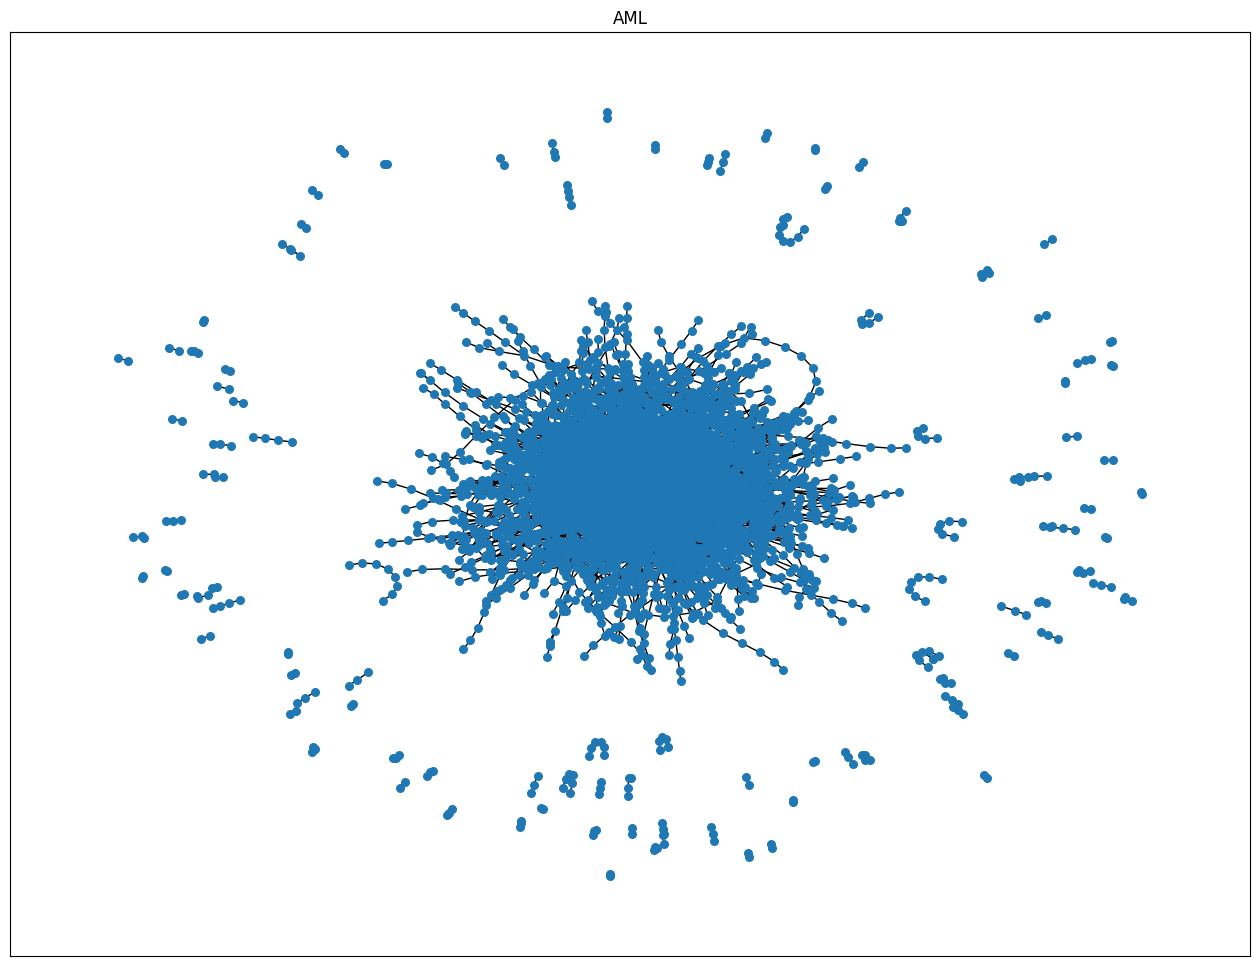

In [6]:
plt.figure(figsize=(16, 12))


G = to_networkx(testdata, to_undirected=True)
pos = nx.spring_layout(G, k=0.1)
nx.draw_networkx(G, with_labels=False, node_size=30)

plt.title('AML');


Node 4867 has the largest degree value 70.


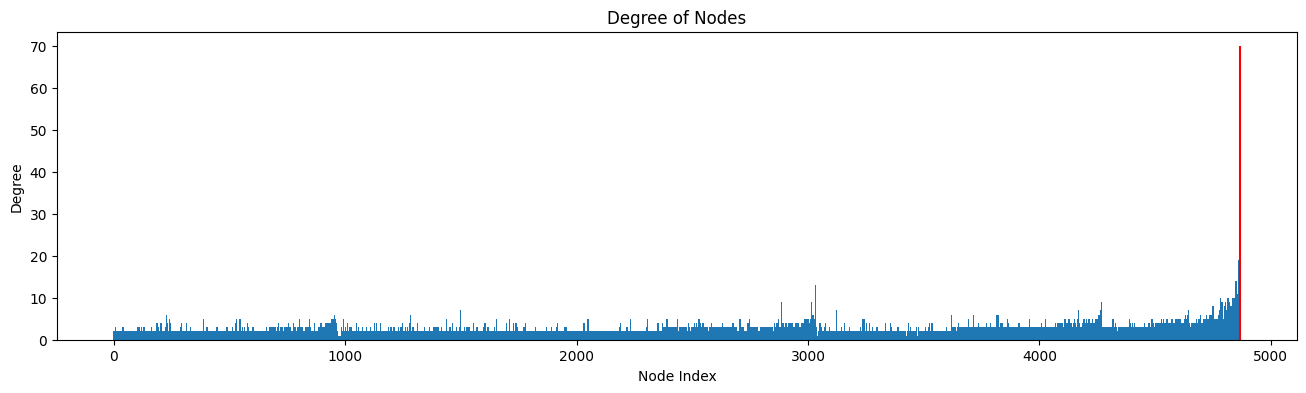

In [7]:
degrees = dict(nx.degree(G))
node_indices = list(degrees.keys())
node_degrees = list(degrees.values())

max_degree = max(node_degrees)
node_idx = np.argmax(node_degrees).item()
plt.figure(figsize=(16, 4))

plt.bar(node_indices, node_degrees, width=5.0)

plt.vlines(x=node_idx, ymin=0, ymax=max_degree, colors='r')

plt.title('Degree of Nodes')
plt.xlabel('Node Index')
plt.ylabel('Degree');

print(f'Node {node_idx} has the largest degree value {max_degree}.')





In [9]:
from torch import nn
from torch_geometric.nn import GCNConv, SAGEConv, GINEConv, GATConv, BatchNorm, Linear
import torch
from tqdm.notebook import tqdm
import torch.optim as optim


In [10]:


class GAT(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim,
                 heads_1=8, heads_2=1, att_dropout=0.6, input_dropout=0.6):
        
        super(GAT, self).__init__()

        self.att_dropout = att_dropout
        self.input_dropout = input_dropout

        self.conv1 = GATConv(in_channels=input_dim,
                             out_channels=hidden_dim // heads_1,
                             heads=heads_1,
                             concat=True,
                             dropout=att_dropout)
        self.conv2 = GATConv(in_channels=hidden_dim,
                             out_channels=output_dim,
                             heads=heads_2,
                             concat=False,
                             dropout=att_dropout)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.input_dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.input_dropout, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [11]:

hparams = {
    'input_dim': 10,
    'hidden_dim': 16,
    'output_dim': 2
}

model = GAT(**hparams)
model

GAT(
  (conv1): GATConv(10, 2, heads=8)
  (conv2): GATConv(16, 2, heads=1)
)

In [12]:
# Tunable hyperparamters
hidden_channels = 10
num_heads = 3
dropout = 0.3
lr = 0.005
epochs = 400
class_weights = [1, 2.5]
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    
    # Model
model = modules.GAT_GraphSVX(in_channels=10,
                                 hidden_channels=hidden_channels,
                                 out_channels=2,
                                 num_heads=num_heads,
                                 dropout=dropout)
    

In [13]:
def accuracy(output, labels):
    _, pred = output.max(dim=1)
    correct = pred.eq(labels).double()
    correct = correct.sum()
    
    return correct / len(labels)

In [14]:
lr = 0.005
epochs = 400
model.train()
optimizer = optim.Adam(model.parameters(), lr=lr)
model.to(device)
for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    output_train = model(traindata.x, traindata.edge_index)

    loss = F.nll_loss(output_train, traindata.y)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        output = model(testdata.x, testdata.edge_index)

        acc = accuracy(output, testdata.y)
        print('Epoch: {:3d}, acc = {:.3f}'.format(epoch, acc))

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch:   0, acc = 0.753
Epoch:  10, acc = 0.907
Epoch:  20, acc = 0.910
Epoch:  30, acc = 0.908
Epoch:  40, acc = 0.910
Epoch:  50, acc = 0.909
Epoch:  60, acc = 0.911
Epoch:  70, acc = 0.909
Epoch:  80, acc = 0.909
Epoch:  90, acc = 0.909
Epoch: 100, acc = 0.910
Epoch: 110, acc = 0.910
Epoch: 120, acc = 0.909
Epoch: 130, acc = 0.904
Epoch: 140, acc = 0.907
Epoch: 150, acc = 0.906
Epoch: 160, acc = 0.908
Epoch: 170, acc = 0.905
Epoch: 180, acc = 0.904
Epoch: 190, acc = 0.906
Epoch: 200, acc = 0.901
Epoch: 210, acc = 0.872
Epoch: 220, acc = 0.860
Epoch: 230, acc = 0.868
Epoch: 240, acc = 0.858
Epoch: 250, acc = 0.860
Epoch: 260, acc = 0.870
Epoch: 270, acc = 0.861
Epoch: 280, acc = 0.863
Epoch: 290, acc = 0.861
Epoch: 300, acc = 0.866
Epoch: 310, acc = 0.857
Epoch: 320, acc = 0.852
Epoch: 330, acc = 0.856
Epoch: 340, acc = 0.854
Epoch: 350, acc = 0.858
Epoch: 360, acc = 0.853
Epoch: 370, acc = 0.846
Epoch: 380, acc = 0.853
Epoch: 390, acc = 0.857


In [15]:
_, pred = output.max(dim=1)
sar_nodes = torch.nonzero(pred == 1).squeeze()
sar_nodes



tensor([   7,   11,   12,   34,   47,   57,   59,   60,   69,   75,   78,   91,
          96,  101,  104,  106,  133,  148,  162,  192,  203,  216,  229,  235,
         243,  249,  262,  273,  292,  299,  303,  305,  311,  331,  334,  340,
         357,  362,  369,  374,  393,  422,  433,  435,  436,  470,  529,  533,
         547,  550,  558,  578,  583,  597,  603,  607,  623,  653,  655,  691,
         708,  738,  739,  742,  755,  757,  778,  781,  782,  786,  802,  816,
         845,  846,  861,  872,  876,  891,  900,  913,  933,  938,  941,  956,
         974,  994, 1027, 1033, 1047, 1052, 1055, 1056, 1057, 1092, 1099, 1109,
        1118, 1126, 1152, 1194, 1221, 1231, 1259, 1262, 1294, 1312, 1318, 1326,
        1335, 1385, 1410, 1414, 1419, 1421, 1437, 1466, 1471, 1484, 1507, 1517,
        1523, 1524, 1525, 1530, 1544, 1559, 1592, 1599, 1604, 1615, 1646, 1653,
        1654, 1672, 1675, 1681, 1690, 1691, 1719, 1723, 1742, 1760, 1829, 1837,
        1847, 1863, 1864, 1866, 1868, 19

WHat? 4645, 4654, 113



In [16]:
# find the nodes with true label 1
true_sar_nodes = torch.nonzero(testdata.y == 1).squeeze()
true_sar_nodes

tensor([   6,   12,   37,   43,  101,  109,  121,  126,  130,  133,  137,  138,
         148,  158,  162,  184,  190,  192,  204,  223,  226,  229,  231,  240,
         246,  288,  292,  315,  317,  328,  329,  331,  339,  355,  386,  399,
         404,  444,  446,  449,  489,  490,  512,  524,  529,  538,  545,  557,
         560,  563,  564,  578,  583,  599,  602,  603,  604,  610,  612,  627,
         643,  645,  649,  659,  671,  712,  729,  736,  755,  774,  776,  786,
         791,  793,  798,  804,  830,  831,  833,  835,  845,  846,  867,  882,
         889,  892,  898,  899,  916,  918,  920,  923,  945,  956,  968,  976,
         985,  988,  992,  994,  995, 1003, 1009, 1018, 1023, 1025, 1026, 1047,
        1057, 1069, 1076, 1091, 1109, 1125, 1135, 1152, 1153, 1159, 1188, 1198,
        1211, 1232, 1238, 1243, 1247, 1248, 1261, 1270, 1276, 1282, 1293, 1312,
        1341, 1351, 1360, 1364, 1374, 1381, 1387, 1392, 1394, 1399, 1401, 1417,
        1436, 1443, 1453, 1463, 1465, 14

In [17]:
# find nodes with predicted label 1 and true label 1
true_positives = torch.nonzero((pred == 1) & (testdata.y == 1)).squeeze()
true_positives

tensor([  12,  101,  133,  148,  162,  192,  229,  292,  331,  529,  578,  583,
         603,  755,  786,  845,  846,  956,  994, 1047, 1057, 1109, 1152, 1312,
        1524, 1604, 1653, 1654, 1742, 1915, 2049, 2457, 2484, 2518, 2546, 2629,
        2749, 2856, 3000, 3016, 3158, 3234, 3247, 3253, 3275, 3425, 3435, 3536,
        3585, 3693, 3730, 3736, 3789, 3833, 3837, 3864, 3953, 3982, 4068, 4165,
        4391, 4401, 4490, 4587, 4627, 4698, 4721, 4789, 4801], device='cuda:0')

In [3]:
node_idx=10
print(f'Prediction probability for node {node_idx}: {torch.exp(model(test_data.x, test_data.edge_index)[node_idx])}')



NameError: name 'model' is not defined

In [47]:
import GraphSVX_explainers
reload(GraphSVX_explainers)
from GraphSVX_explainers import  GraphLIME
reload(GraphSVX_explainers)

from torch_geometric.data import Data

from graphlime import GraphLIME

In [48]:
explainer=GraphLIME(testdata,model,hop=3,rho=0.1)
coefs=explainer.explain(node_idx,testdata.x,testdata.edge_index)
#coefs2=explainer.explain_node(node_idx,test_data.x,test_data.edge_index)

Kbar: [[ 1.08840400e-02  4.72523309e-02  4.30396944e-02  4.45187092e-01
   9.09093488e-03  1.50246963e-01  1.62465274e-02  4.25915010e-02
   4.52645496e-02  5.45105115e-02]
 [ 1.06862038e-02  4.65220362e-02  4.27184552e-02  1.82179555e-01
  -1.29675877e-03  1.18557937e-01  1.62465274e-02  4.25915010e-02
  -5.07503077e-02  5.45105115e-02]
 [ 7.89887831e-03  3.15378830e-02  3.49530540e-02 -1.51213706e-01
  -4.01908485e-03  5.00523746e-02  1.62465274e-02  4.25915010e-02
  -5.07503077e-02  5.45105115e-02]
 [ 2.41461713e-02  4.86019999e-02  4.40552272e-02 -6.06842414e-02
  -3.14219370e-02  4.35147248e-02 -4.74513844e-02  4.25915010e-02
  -1.42853081e-01  5.45105115e-02]
 [ 3.60253043e-02  5.26764058e-02  4.45401855e-02 -9.38020926e-03
  -4.27348278e-02  8.48467201e-02 -7.95359462e-02  4.25915010e-02
   4.52645496e-02  5.45105115e-02]
 [-2.48513483e-02 -1.21284157e-01 -1.24673530e-01 -4.14603859e-01
   2.81274039e-03 -1.72478884e-01  1.62465274e-02 -6.52659163e-02
   4.52645496e-02 -9.626334

In [49]:
coefs


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

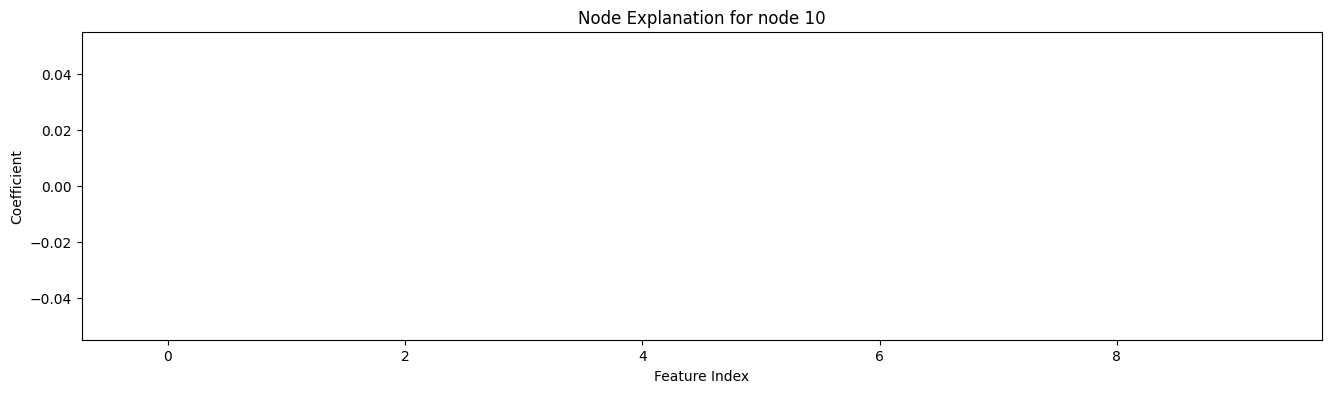

Model prediction of node 10: 0, with true label: 0
Node 10 feature vector: tensor([[1.1778e+03, 5.8888e+02, 5.8888e+02, 7.5123e+01, 6.4200e+02, 5.3576e+02,
         2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00]], device='cuda:0')


In [50]:
#Plot the coefficients in a bar chart
plt.figure(figsize=(16, 4))
plt.bar(range(len(coefs)), coefs, width=0.5)
plt.title(f'Node Explanation for node {node_idx}')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient')
plt.show()

print(f'Model prediction of node {node_idx}: {model(test_data.x, test_data.edge_index)[node_idx].argmax().item()}, with true label: {testdata.y[node_idx]}')

#print the feature vector of the node mapped to the original feature values - revert normalization
print(f'Node {node_idx} feature vector: {testdata.x[node_idx]*std+mean}')



In [26]:
# if testdata.edge_index[0]==node_index store the edge_index
edge_index = testdata.edge_index[:,testdata.edge_index[0]==node_idx]
edge_index

tensor([[  11,   11],
        [2049, 4842]], device='cuda:0')

In [27]:
print('hello world')

hello world


In [23]:
#print number of nodes
print(f'Number of nodes: {testdata.num_nodes}')
zero_nodes=[]
for n in range(testdata.num_nodes):
    coefs=explainer.explain(n,test_data.x,test_data.edge_index, printing=False)
    if sum(coefs)==0:
        zero_nodes.append(n)
print(f'Number of nodes with zero explanation: {len(zero_nodes)}')

Number of nodes: 4868
Number of nodes with zero explanation: 591


In [24]:
zero_nodes

[6,
 8,
 10,
 14,
 16,
 19,
 34,
 35,
 39,
 41,
 46,
 54,
 57,
 91,
 102,
 111,
 116,
 117,
 128,
 144,
 155,
 160,
 174,
 178,
 179,
 186,
 189,
 193,
 197,
 211,
 216,
 220,
 227,
 229,
 232,
 254,
 261,
 264,
 266,
 275,
 282,
 300,
 303,
 307,
 318,
 331,
 333,
 349,
 367,
 369,
 390,
 392,
 396,
 431,
 450,
 470,
 471,
 484,
 487,
 498,
 510,
 524,
 542,
 543,
 562,
 564,
 570,
 571,
 577,
 578,
 580,
 587,
 599,
 600,
 605,
 621,
 623,
 630,
 637,
 642,
 653,
 671,
 678,
 683,
 684,
 685,
 694,
 699,
 705,
 715,
 719,
 735,
 738,
 739,
 741,
 745,
 762,
 768,
 786,
 789,
 806,
 812,
 813,
 823,
 829,
 830,
 846,
 848,
 851,
 861,
 869,
 875,
 889,
 892,
 894,
 906,
 910,
 939,
 943,
 944,
 953,
 962,
 963,
 971,
 987,
 989,
 990,
 993,
 1000,
 1003,
 1007,
 1016,
 1018,
 1025,
 1027,
 1029,
 1047,
 1055,
 1056,
 1058,
 1074,
 1077,
 1086,
 1097,
 1117,
 1122,
 1123,
 1131,
 1142,
 1151,
 1154,
 1186,
 1204,
 1221,
 1226,
 1228,
 1238,
 1239,
 1241,
 1245,
 1265,
 1267,
 1273,
 12

In [134]:
for n in zero_nodes:
    edge_index = testdata.edge_index[:,testdata.edge_index[0]==n]
    print(n)
    print(edge_index)


6
tensor([[   6,    6,    6],
        [ 184, 3226, 4456]], device='cuda:0')
10
tensor([[  10],
        [4071]], device='cuda:0')
11
tensor([[  11,   11],
        [2049, 4842]], device='cuda:0')
14
tensor([[  14],
        [4275]], device='cuda:0')
16
tensor([[ 16],
        [963]], device='cuda:0')
25
tensor([[  25],
        [4841]], device='cuda:0')
34
tensor([[  34,   34],
        [4064, 4801]], device='cuda:0')
35
tensor([[  35,   35],
        [3128, 4867]], device='cuda:0')
39
tensor([[  39],
        [3428]], device='cuda:0')
41
tensor([[  41,   41],
        [4851, 4866]], device='cuda:0')
46
tensor([[  46,   46],
        [3046, 4164]], device='cuda:0')
54
tensor([[  54,   54],
        [1104, 4530]], device='cuda:0')
57
tensor([[  57],
        [4867]], device='cuda:0')
61
tensor([[  61],
        [2158]], device='cuda:0')
91
tensor([[  91,   91],
        [4708, 4865]], device='cuda:0')
96
tensor([[  96,   96],
        [3693, 4863]], device='cuda:0')
106
tensor([[ 106,  106],
        [

804
tensor([[ 804,  804,  804,  804,  804],
        [ 994, 2781, 4170, 4461, 4500]], device='cuda:0')
805
tensor([[ 805,  805,  805],
        [3336, 4524, 4858]], device='cuda:0')
812
tensor([[ 812,  812],
        [4551, 4867]], device='cuda:0')
813
tensor([[ 813,  813,  813],
        [1047, 3965, 4395]], device='cuda:0')
823
tensor([[ 823],
        [4867]], device='cuda:0')
829
tensor([[ 829,  829],
        [2796, 4859]], device='cuda:0')
830
tensor([[ 830,  830,  830],
        [1025, 2259, 4467]], device='cuda:0')
846
tensor([[ 846,  846,  846,  846,  846],
        [3536, 3595, 3632, 3819, 4390]], device='cuda:0')
848
tensor([[ 848],
        [3372]], device='cuda:0')
851
tensor([[ 851,  851,  851],
        [4752, 4819, 4867]], device='cuda:0')
861
tensor([[ 861],
        [3160]], device='cuda:0')
869
tensor([[ 869,  869],
        [4648, 4867]], device='cuda:0')
875
tensor([[ 875,  875],
        [2112, 2165]], device='cuda:0')
889
tensor([[ 889,  889],
        [2887, 4867]], device='c